<font size="6"><b>Modeling Sandbox 1</b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

from sklearn import metrics, linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from random import sample

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats


# Data Loading & QC

In [2]:
dfm = pd.read_csv('dfm.csv', index_col=0)
dfm.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
0,United Airlines,Newark,Denver,3,-5.0,15.0,3,3,10.0,3,-23.0,268.0,250.0,225.0,1605.0,1,1,0,0
1,United Airlines,Las Vegas,San Francisco,2,-8.0,11.0,2,3,7.0,3,-24.0,99.0,83.0,65.0,414.0,1,1,0,0
2,United Airlines,Santa Ana,Denver,3,-5.0,15.0,3,3,5.0,3,-13.0,134.0,126.0,106.0,846.0,1,1,0,0
3,United Airlines,Ft. Myers,Chicago,3,6.0,19.0,3,3,6.0,3,-2.0,190.0,182.0,157.0,1120.0,1,1,0,0
6,United Airlines,Houston,Las Vegas,2,-3.0,14.0,2,2,6.0,2,-16.0,206.0,193.0,173.0,1222.0,1,1,0,0


In [3]:
dfm.CRS_DEP_TIME.value_counts(normalize=True)

2    0.384188
3    0.365040
4    0.180800
1    0.069971
Name: CRS_DEP_TIME, dtype: float64

In [4]:
dfm.CRS_ARR_TIME.value_counts(normalize=True)

3    0.351728
2    0.314401
4    0.307390
1    0.026481
Name: CRS_ARR_TIME, dtype: float64

In [5]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   OP_CARRIER           object 
 1   ORIGIN               object 
 2   DEST                 object 
 3   CRS_DEP_TIME         int64  
 4   DEP_DELAY            float64
 5   TAXI_OUT             float64
 6   WHEELS_OFF           int64  
 7   WHEELS_ON            int64  
 8   TAXI_IN              float64
 9   CRS_ARR_TIME         int64  
 10  ARR_DELAY            float64
 11  CRS_ELAPSED_TIME     float64
 12  ACTUAL_ELAPSED_TIME  float64
 13  AIR_TIME             float64
 14  DISTANCE             float64
 15  DAY                  int64  
 16  MONTH                int64  
 17  FLIGHT_STATUS        int64  
 18  WEEKDAY              int64  
dtypes: float64(8), int64(8), object(3)
memory usage: 607.6+ MB


In [6]:
dfm.shape

(3982067, 19)

In [7]:
dfm.isna().sum()

OP_CARRIER             0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_DELAY              0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
DAY                    0
MONTH                  0
FLIGHT_STATUS          0
WEEKDAY                0
dtype: int64

# Data Distribution


In [11]:
def scaling_check(data):
    
    case_count = dfm['FLIGHT_STATUS'].value_counts() # 'data' is our input which will be any of the 3 dataframes created
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x=case_count.index, y=case_count.values)
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.title('Data Distribution', fontsize=16)
    plt.xlabel('Flight Status', fontsize=12)
    plt.ylabel('Number of Flights', fontsize=12)
    plt.xticks(range(len(case_count.index)), ['ON TIME(0)', 'DELAYED(1)'])
    plt.show()

Legend:
0    2503954
1    1478113
Name: FLIGHT_STATUS, dtype: int64


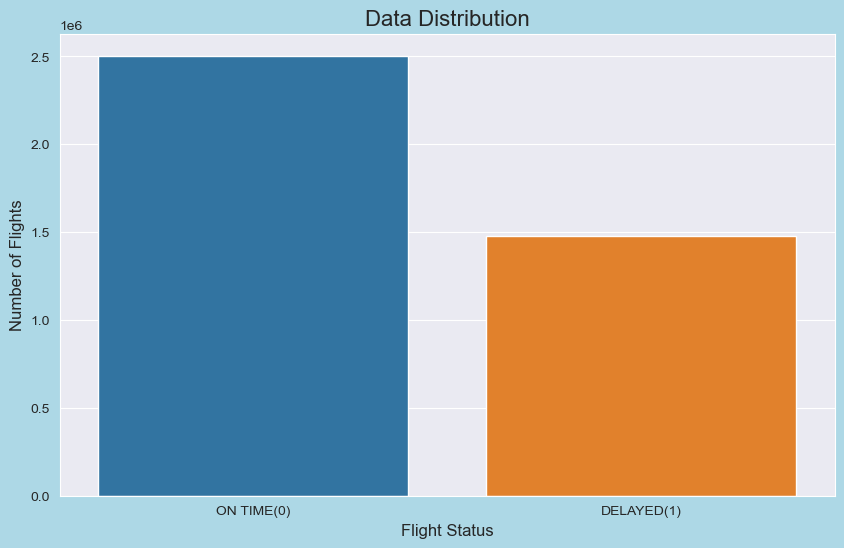

In [12]:
scaling_check(dfm)

In [13]:
dfm.FLIGHT_STATUS.value_counts(normalize=True)

0    0.628808
1    0.371192
Name: FLIGHT_STATUS, dtype: float64

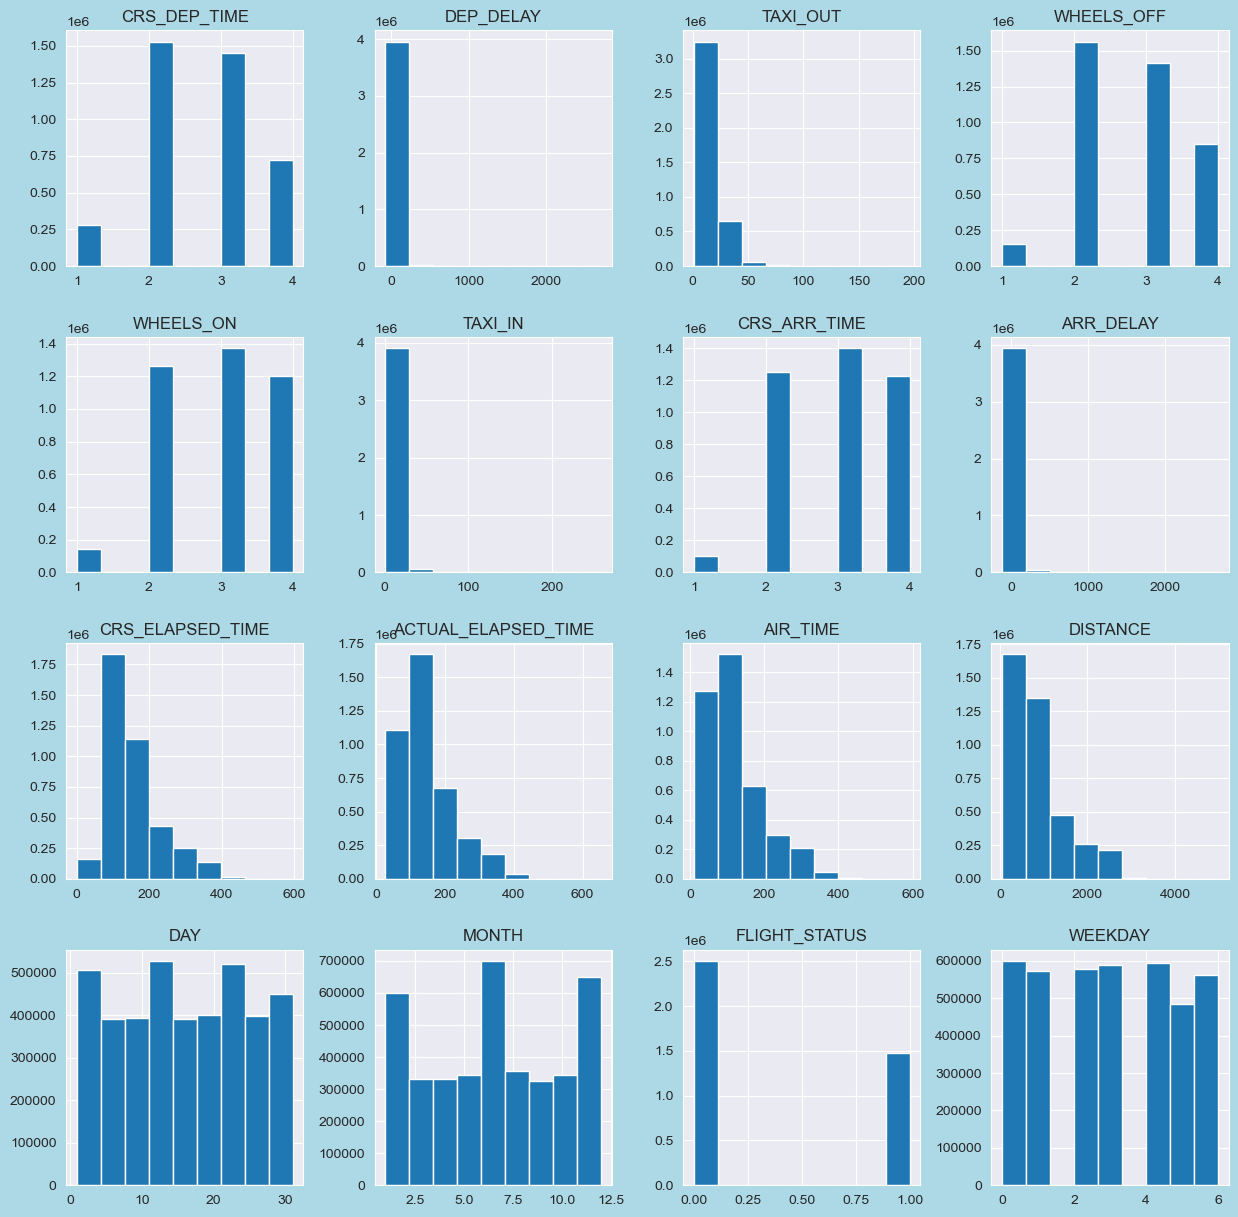

In [14]:
dfm.hist(figsize  = [15, 15],bins=9) 
plt.show()

In [15]:
dfm.DEP_DELAY.value_counts(normalize=True)

-5.0       7.629304e-02
-4.0       7.321298e-02
-3.0       7.112336e-02
-6.0       6.491955e-02
-2.0       6.459962e-02
               ...     
 1271.0    2.511259e-07
 1445.0    2.511259e-07
 1458.0    2.511259e-07
 1394.0    2.511259e-07
 1307.0    2.511259e-07
Name: DEP_DELAY, Length: 1431, dtype: float64

In [16]:
dfm_test=dfm[(dfm['DEP_DELAY'] > 1000)]
dfm_test

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,MONTH,FLIGHT_STATUS,WEEKDAY
7521,SkyWest Airlines,Eau Claire,Chicago,1,1041.0,18.0,4,4,7.0,2,1032.0,82.0,73.0,48.0,269.0,1,1,1,0
8227,SkyWest Airlines,Atlanta,Chicago,3,1140.0,26.0,2,2,13.0,3,1144.0,130.0,134.0,95.0,606.0,1,1,1,0
14275,American Airlines,Eagle,Dallas-Fort Worth,3,1144.0,17.0,2,3,14.0,4,1135.0,133.0,124.0,93.0,721.0,1,1,1,0
14636,American Airlines,Detroit,Dallas-Fort Worth,3,1013.0,34.0,2,2,8.0,4,1001.0,189.0,177.0,135.0,986.0,1,1,1,0
21972,Spirit Airlines,Detroit,Denver,3,1332.0,48.0,3,3,9.0,4,1345.0,202.0,215.0,158.0,1123.0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202763,United Airlines,Eagle,Newark,3,1306.0,18.0,2,3,8.0,4,1271.0,241.0,206.0,180.0,1725.0,31,12,1,0
7203678,Endeavor Air,Traverse City,Detroit,3,1231.0,21.0,3,3,12.0,4,1226.0,78.0,73.0,40.0,207.0,31,12,1,0
7211246,SkyWest Airlines,Minneapolis,Houston,4,1074.0,20.0,3,3,10.0,4,1068.0,192.0,186.0,156.0,1034.0,31,12,1,0
7212368,SkyWest Airlines,Aspen,San Francisco,4,1041.0,29.0,3,3,8.0,4,1026.0,156.0,141.0,104.0,848.0,31,12,1,0


# Categoricals

The Categoricals to deal with are:<br>

* OP_CARRIER = 18 airlines<br>
* ORIGIN = 20 cities<br>
* DEST = 20 cities<br>
* CRS_DEP_TIME = 4 quarters<br>
* CRS_ARR_TIME = 4 quarters<br>
* MONTH = 12 months<br>
* FLIGHT_STATUS = 2 categories (already dealt with)<br>
* WEEKDAY



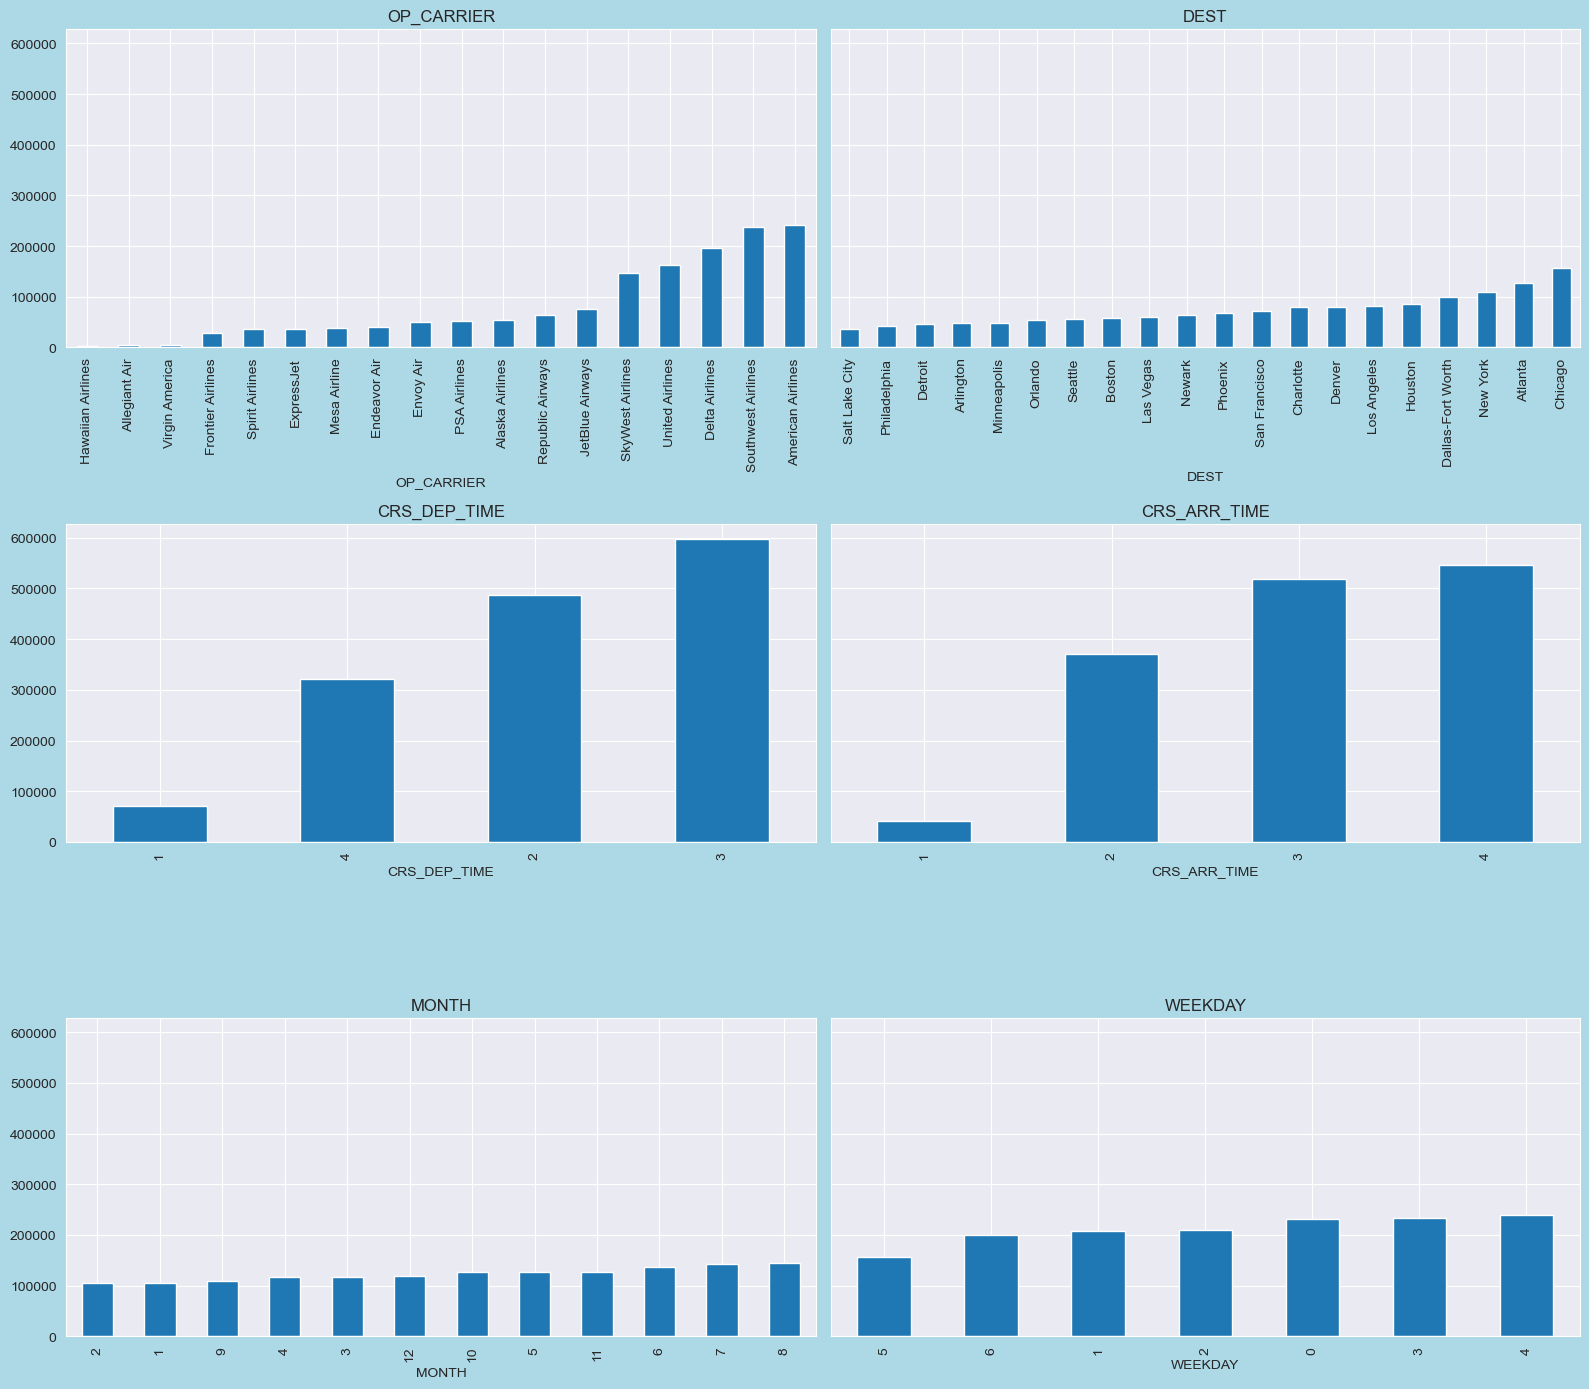

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14), sharey=True)

categoricals = ['OP_CARRIER', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY']

for col, ax in zip(categoricals, axes.flatten()):
    (dfm.groupby(col).sum()['FLIGHT_STATUS'].sort_values().plot.bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()


In [19]:
OP_CARRIER_dummies = pd.get_dummies(dfm['OP_CARRIER'], prefix='OP_CARRIER', drop_first=True)
DEST_dummies = pd.get_dummies(dfm['DEST'], prefix='DEST', drop_first=True)
CRS_DEP_TIME_dummies = pd.get_dummies(dfm['CRS_DEP_TIME'], prefix='CRS_DEP_TIME', drop_first=True)
CRS_ARR_TIME_dummines = pd.get_dummies(dfm['CRS_ARR_TIME'], prefix='CRS_ARR_TIME', drop_first=True) 
MONTH_dummies = pd.get_dummies(dfm['MONTH'], prefix='MONTH', drop_first=True)
WEEKDAY_dummies = pd.get_dummies(dfm['WEEKDAY'], prefix='WEEKDAY', drop_first=True)

In [20]:
dfm = dfm.drop(['OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'MONTH', 'WEEKDAY'], axis=1)

In [21]:
dfm = pd.concat([dfm, OP_CARRIER_dummies, DEST_dummies, CRS_DEP_TIME_dummies, CRS_ARR_TIME_dummines, MONTH_dummies, WEEKDAY_dummies], axis=1)

In [22]:
dfm.head(2)

,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,15.0,3,3,10.0,-23.0,268.0,250.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,2,3,7.0,-24.0,99.0,83.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
dfm.shape

(3982067, 71)

# Random Forest

In [26]:
# Create features (X) and labels (y)
y = dfm['FLIGHT_STATUS']
X = dfm.drop(['FLIGHT_STATUS'], axis=1)

In [27]:
# Perform the split
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
# Build a regular tree as baseline
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight="balanced")
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

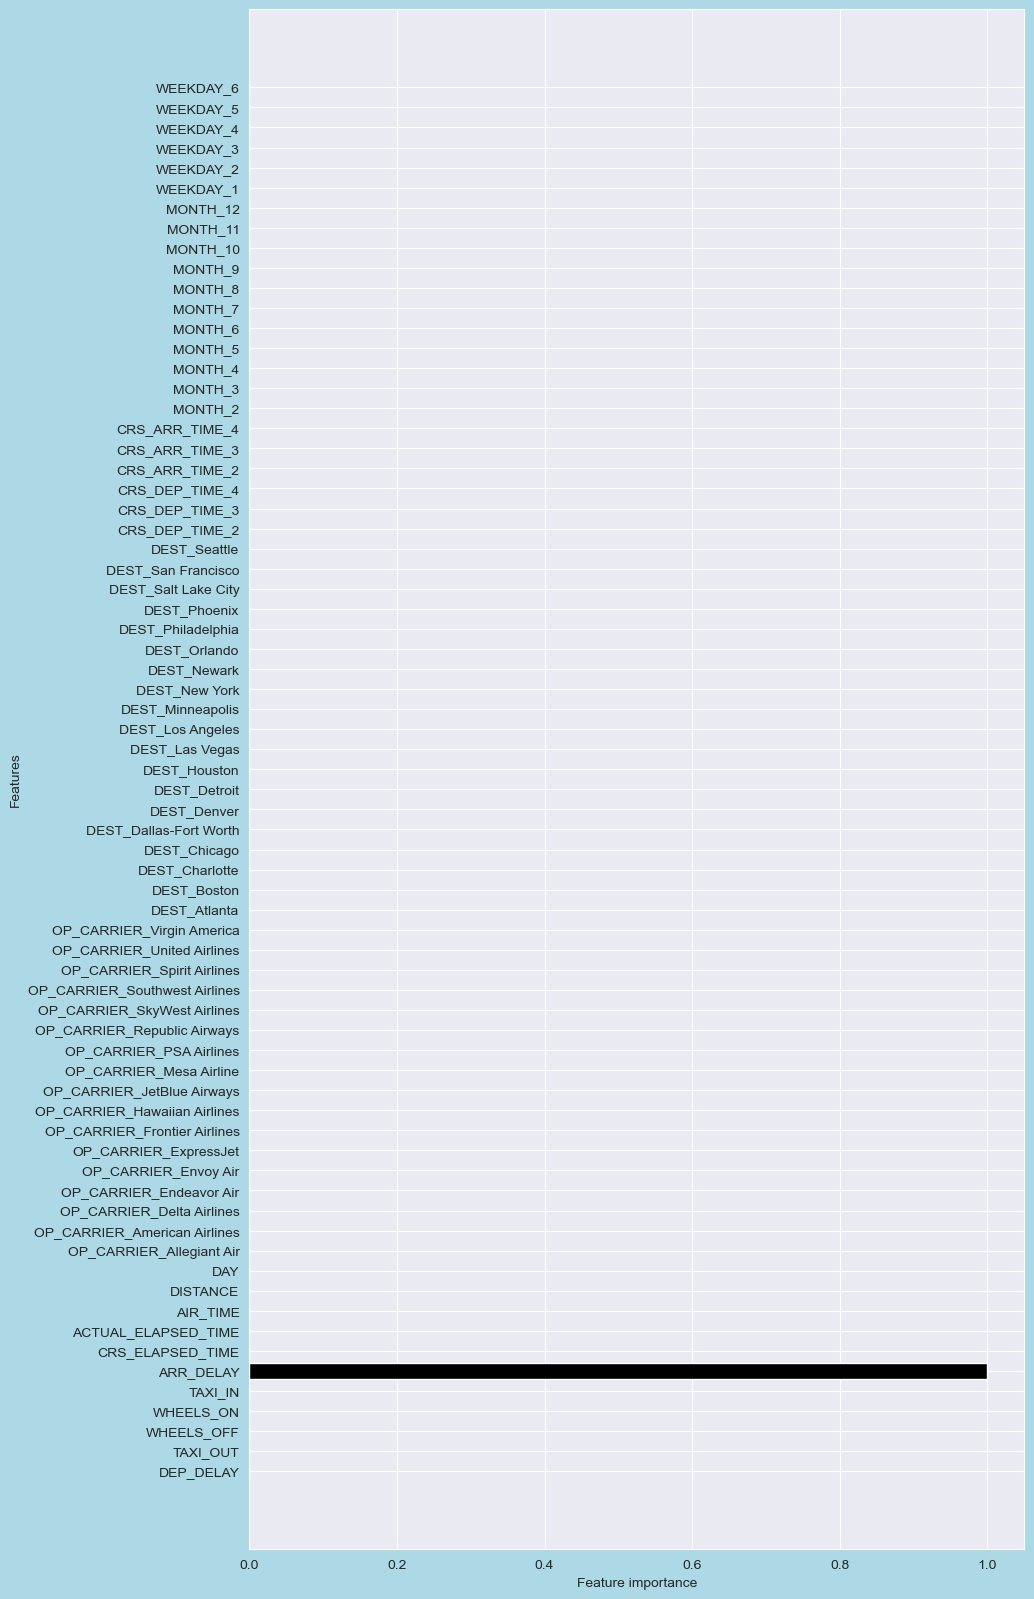

In [29]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), model.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)
plot_feature_importances(tree_clf)

<b>Model Performance</b>

In [30]:
# Test set predictions
pred = tree_clf.predict(X_test)

In [31]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,2003024,0,2003024
1,0,1182629,1182629
All,2003024,1182629,3185653


In [32]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2003024
           1       1.00      1.00      1.00   1182629

    accuracy                           1.00   3185653
   macro avg       1.00      1.00      1.00   3185653
weighted avg       1.00      1.00      1.00   3185653



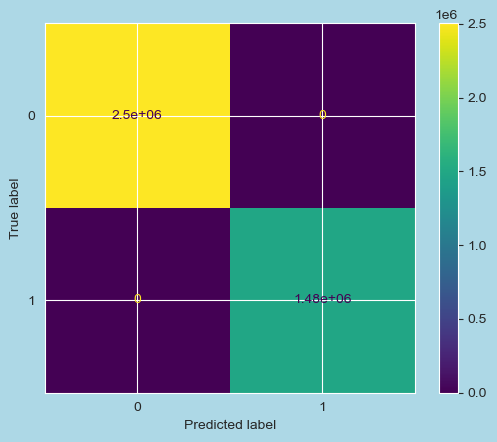

In [33]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf, X, y, values_format='.3g')
plt.show()

In [34]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 100.0%


<b>BAGGED TREES</b>

In [35]:
# We start by instantiating the BaggingClassifire
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [36]:
# Now to fitting the training data:
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [37]:
# I'm going to call the .score() to obtain the accuracy score on the training dataset and then on the test data:
bagged_tree.score(X_train, y_train)

1.0

In [38]:
bagged_tree.score(X_test, y_test)

1.0

<b>RANDOM FOREST</b>

In [39]:
# We'll start by instantiating the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [40]:
# Now to check the accuracy score
forest.score(X_train, y_train)

0.9986137862970766

In [41]:
# And for the test set:
forest.score(X_test, y_test)

0.9985648154397231

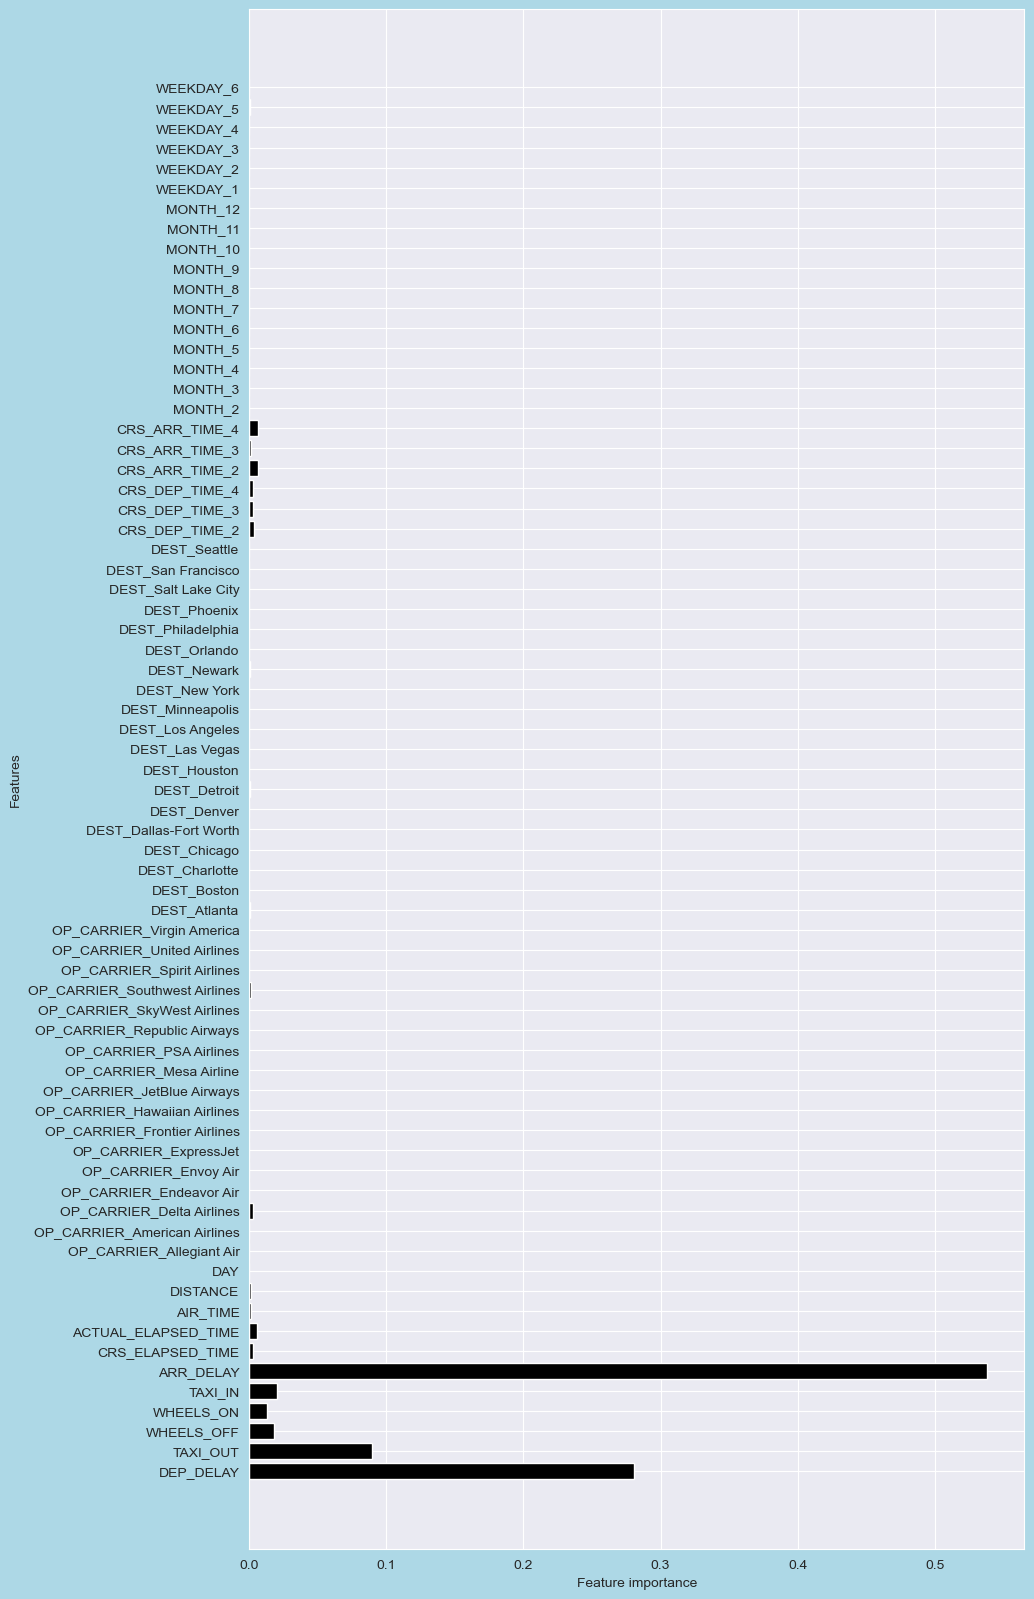

In [42]:
plot_feature_importances(forest)
plt.rcParams["figure.facecolor"] = "lightblue"

<b>LOOKING AT THE TREES INSIDE THE FOREST</b>

In [43]:
# Instantiate and fit a RandomForestClassifier
forest_2 = RandomForestClassifier(n_estimators=5, max_features=10, max_depth= 2)
forest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=10, n_estimators=5)

In [44]:
# First tree from forest_2
rf_tree_1 = forest_2.estimators_[0]

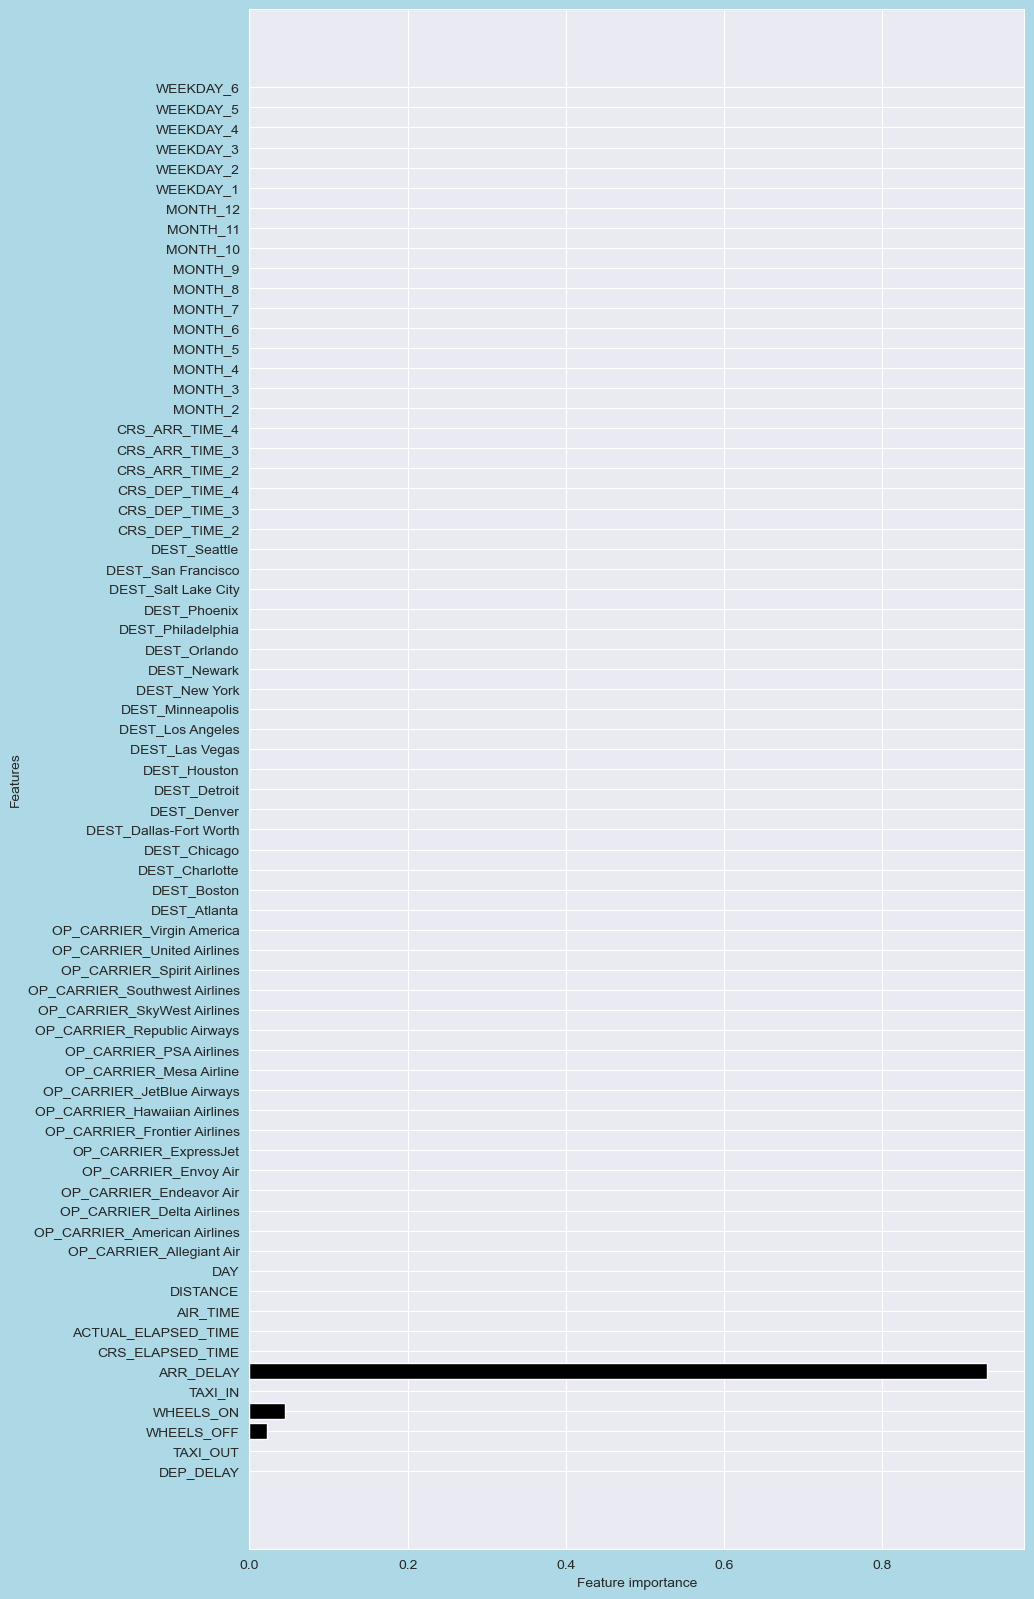

In [45]:
#I'll have a look at the tree's feature importance using the "plot_feature_importances()" function:
plot_feature_importances(rf_tree_1)

In [46]:
# Second tree from forest_2
rf_tree_2 = forest_2.estimators_[1]

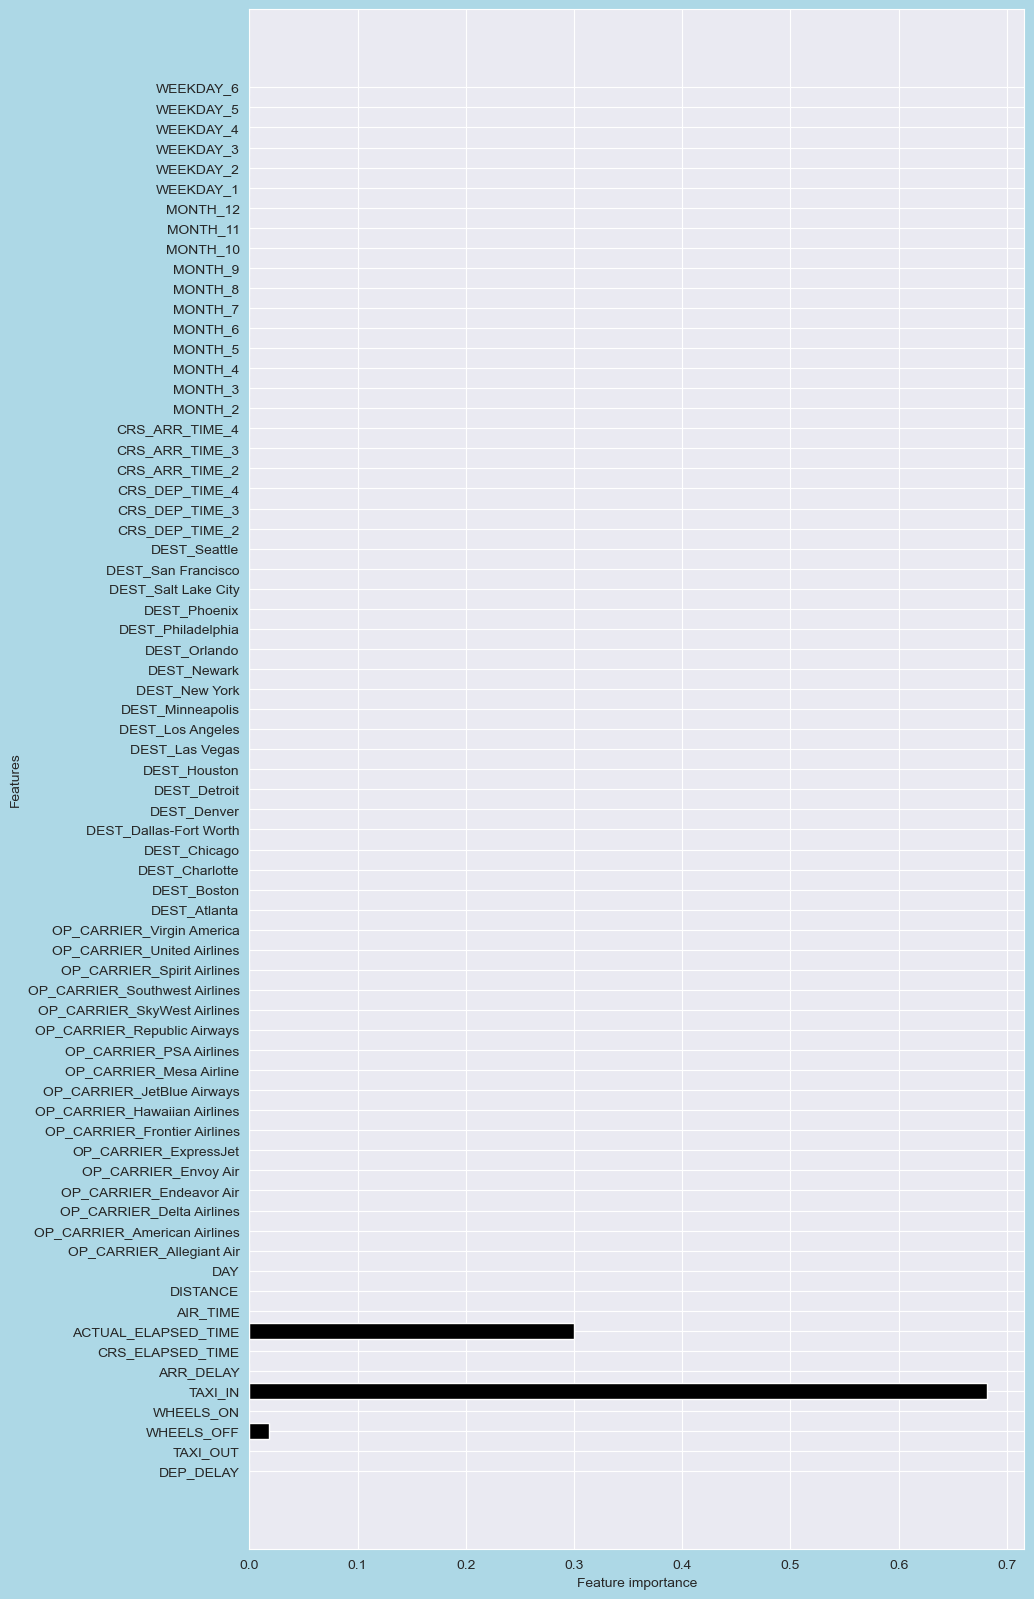

In [47]:
# Feature importance plot
plot_feature_importances(rf_tree_2)